In [ ]:
# Dataset Link
# # https://openml.org/search?type=data&status=active&id=43664

In [ ]:
import pandas as pd

# Loading the CSV file
df = pd.read_csv("C:/Users/nithe/OneDrive/Desktop/UMBC/IS_Sem_2/IS_733/Assignment_1/tech_mental_health.csv")

print(df.head())

# Check column names
print(df.columns)

# Check data types
print(df.dtypes)

# Check for missing values
print(df.isnull().sum())


# 1. Triming whitespace from column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# 2. Remove unnamed columns and 'comments' column
df = df.loc[:, ~df.columns.str.contains('^unnamed', case=False)]
df = df.drop(columns=['comments'], errors='ignore')

# 3. Handle missing values
# Fill missing values in categorical columns with 'Unknown'
categorical_cols = ['self_employed', 'work_interfere', 'state']
for col in categorical_cols:
    df[col] = df[col].fillna('Unknown')

# Replace question marks with 'Prefer not to say'
df[['state', 'work_interfere', 'self_employed']] = df[['state', 'work_interfere', 'self_employed']].replace('?', 'Prefer not to say')

# Fill missing values in numerical columns with median
if 'age' in df.columns:
    df['age'] = pd.to_numeric(df['age'], errors='coerce')  # Ensure age is numeric
    df['age'] = df['age'].fillna(df['age'].median())

# 4. Convert Timestamp to datetime format
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# 5. Clean age column (filter out unrealistic values)
df = df[(df['age'] >= 10) & (df['age'] <= 100)]

# 6. Normalize gender values
def clean_gender(gender):
    gender = str(gender).strip().lower()
    if gender in ['male', 'm', 'man', 'malr']:
        return 'male'
    elif gender in ['female', 'f', 'woman', 'femake']:
        return 'female'
    else:
        return 'other'

df['gender'] = df['gender'].apply(clean_gender)

# 7. Convert binary categorical columns to 'Yes'/'No'
binary_cols = ['self_employed', 'treatment', 'remote_work', 'tech_company', 'benefits']
for col in binary_cols:
    df[col] = df[col].replace({1: 'Yes', 0: 'No', 'yes': 'Yes', 'no': 'No'}).fillna('Unknown')


# 8. Remove duplicates
df = df.drop_duplicates()

# 9. Explicitly drop columns starting with 'unnamed'
df = df.loc[:, ~df.columns.str.startswith('unnamed')]


# Save the cleaned dataset
df.to_csv('tech_mental_health_cleaned.csv', index=False)

print("Data cleaning complete. Cleaned file saved as 'tech_mental_health_cleaned.csv'.")


               Timestamp   Age  Gender           Country  state  \
0  '2014-08-27 11:29:31'    37  Female   'United States'     IL   
1  '2014-08-27 11:29:37'    44       M   'United States'     IN   
2  '2014-08-27 11:29:44'    32    Male            Canada      ?   
3  '2014-08-27 11:29:46'    31    Male  'United Kingdom'      ?   
4  '2014-08-27 11:30:22'    31    Male   'United States'     TX   

   self_employed  family_history  treatment  work_interfere      no_employees  \
0              ?              No        Yes           Often              6-25   
1              ?              No         No          Rarely  'More than 1000'   
2              ?              No         No          Rarely              6-25   
3              ?             Yes        Yes           Often            26-100   
4              ?              No         No           Never           100-500   

   ...  mental_health_consequence  phys_health_consequence       coworkers  \
0  ...                         N

In [19]:
import pandas as pd
import sweetviz as sv

df = pd.read_csv('tech_mental_health_cleaned.csv', encoding='latin-1')
report = sv.analyze(df)

report.show_html()

c:\Users\nithe\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:01 -> (00:00 left)


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


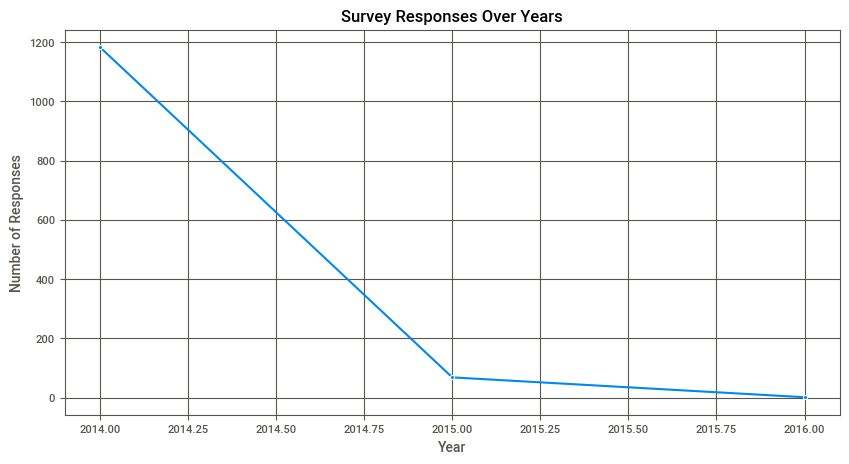

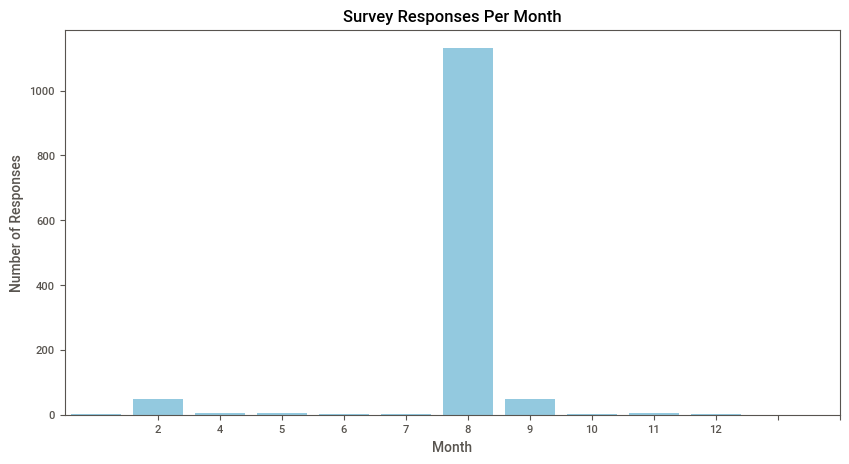

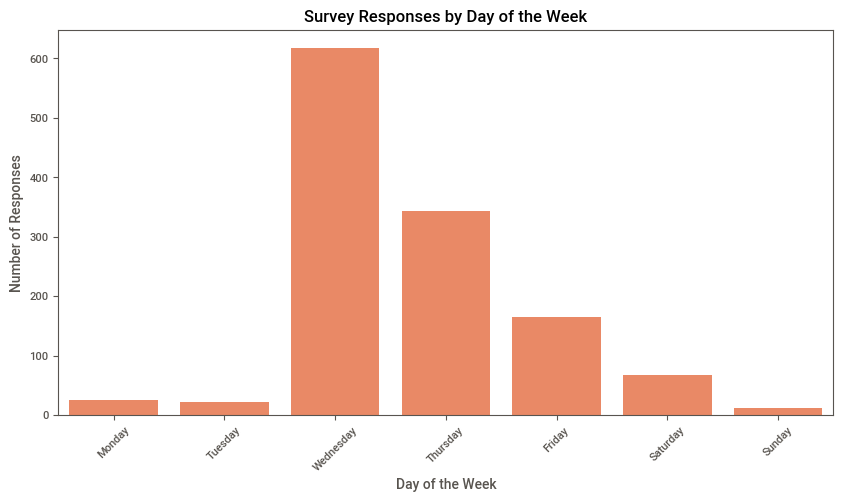

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'Timestamp' to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')


# Extract Year, Month, and Day of the Week
df['Year'] = df['timestamp'].dt.year
df['Month'] = df['timestamp'].dt.month
df['Day_of_Week'] = df['timestamp'].dt.day_name()

# Yearly trend
yearly_counts = df['Year'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
sns.lineplot(x=yearly_counts.index, y=yearly_counts.values, marker='o')
plt.title("Survey Responses Over Years")
plt.xlabel("Year")
plt.ylabel("Number of Responses")
plt.grid(True)
plt.show()

# Monthly trend
monthly_counts = df['Month'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
sns.barplot(x=monthly_counts.index, y=monthly_counts.values, color='skyblue')
plt.title("Survey Responses Per Month")
plt.xlabel("Month")
plt.ylabel("Number of Responses")
plt.xticks(range(1, 13))
plt.show()

# Day-of-Week trend
day_of_week_counts = df['Day_of_Week'].value_counts()

plt.figure(figsize=(10, 5))
sns.barplot(x=day_of_week_counts.index, y=day_of_week_counts.values, color='coral', order=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title("Survey Responses by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Responses")
plt.xticks(rotation=45)
plt.show()



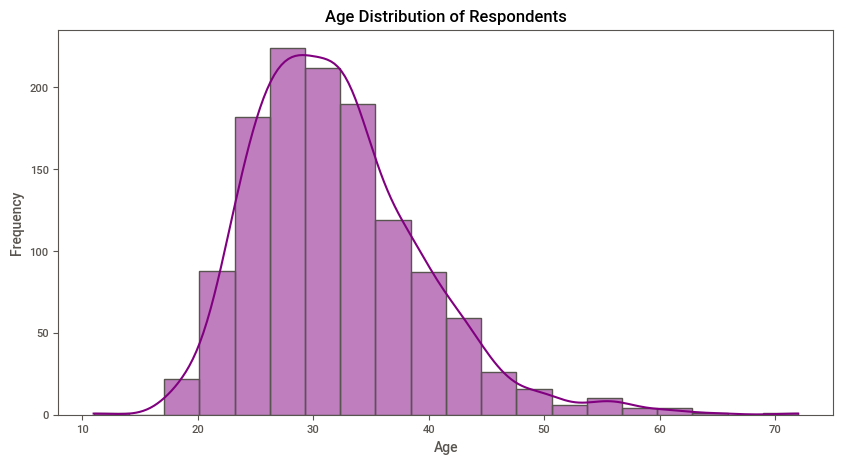

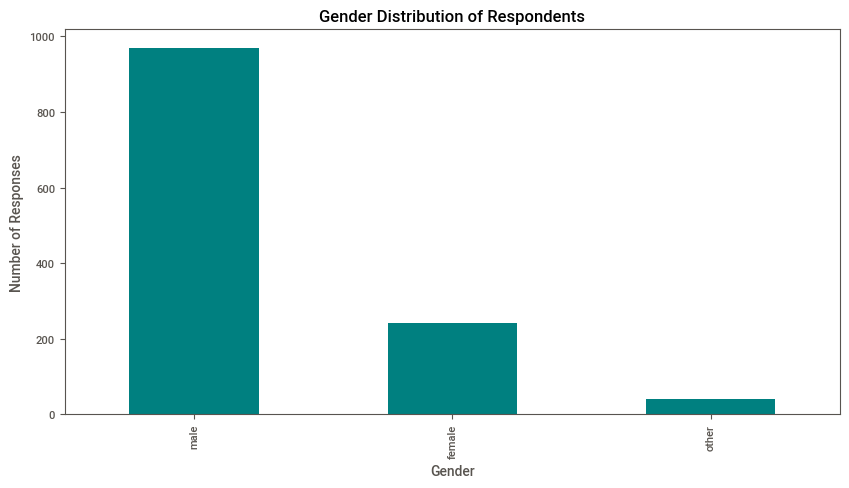

In [22]:
# Age distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['age'], bins=20, kde=True, color='purple')
plt.title('Age Distribution of Respondents')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Gender distribution
plt.figure(figsize=(10, 5))
df['gender'].value_counts().plot(kind='bar', color='teal')
plt.title('Gender Distribution of Respondents')
plt.xlabel('Gender')
plt.ylabel('Number of Responses')
plt.show()

In [21]:
import dash
from dash import dcc, html, Input, Output
import plotly.express as px
import pandas as pd

# Load dataset
file_path = "C:/Users/nithe/OneDrive/Desktop/UMBC/IS_Sem_2/IS_733/Assignment_1/tech_mental_health_cleaned.csv"
df = pd.read_csv(file_path)

# Debug: Print available columns
print("Columns in dataset:", df.columns.tolist())

# Data Preprocessing
df.columns = df.columns.str.strip()
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['Year'] = df['timestamp'].dt.year
df['Month'] = df['timestamp'].dt.month
df['Day_of_Week'] = df['timestamp'].dt.day_name()

# Ensure 'Age' and 'Country' exist
if 'age' not in df.columns or 'country' not in df.columns:
    raise ValueError("Missing required columns: 'Age' or 'Country'")

# Convert 'Age' to numeric, remove invalid values
df['age'] = pd.to_numeric(df['age'], errors='coerce')
df = df.dropna(subset=['age', 'country', 'treatment'])  # Ensure no missing values

# Ensure categorical variables are treated as strings
df['country'] = df['country'].astype(str)
df['treatment'] = df['treatment'].astype(str)

# Initialize Dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Mental Health Survey Dashboard"),

    dcc.Dropdown(
        id='category-dropdown',
        options=[
            {'label': 'Family History', 'value': 'family_history'},
            {'label': 'Work Interference', 'value': 'work_interfere'},
            {'label': 'Gender', 'value': 'gender'}
        ],
        value='family_history'
    ),
    dcc.Graph(id='treatment-trend'),

    dcc.Graph(id='treatment-by-age'),
    dcc.Graph(id='country-wise-treatment')
])

# Callback: Treatment Trend by Selected Category
@app.callback(
    Output('treatment-trend', 'figure'),
    Input('category-dropdown', 'value')
)
def update_treatment_graph(selected_category):
    if selected_category not in df.columns:
        return px.histogram(title="Invalid Selection: Column Not Found")

    fig = px.histogram(df, x=selected_category, color='treatment', barmode='group',
                       title=f'Treatment Trends by {selected_category}')
    return fig

# Callback: Treatment by Age
@app.callback(
    Output('treatment-by-age', 'figure'),
    Input('category-dropdown', 'value')
)
def update_treatment_by_age_graph(_):
    if df.empty:
        return px.histogram(title="No Data Available")

    fig = px.histogram(df, x='age', color='treatment', barmode='overlay',
                       title='Mental Health Treatment by Age')
    return fig

# Callback: Country-wise Treatment Distribution
@app.callback(
    Output('country-wise-treatment', 'figure'),
    Input('category-dropdown', 'value')
)
def update_country_treatment_graph(_):
    if df.empty:
        return px.histogram(title="No Data Available")

    fig = px.histogram(df, x='country', color='treatment', barmode='group',
                       title='Mental Health Treatment Across Countries')
    return fig



# Run Dash app
app.run_server(debug=True, host='127.0.0.1')

Columns in dataset: ['timestamp', 'age', 'gender', 'country', 'state', 'self_employed', 'family_history', 'treatment', 'work_interfere', 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence']
